In [2]:
from IPython.display import Audio
import librosa
from librosa import display
import numpy as np
import scipy
from matplotlib import pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plt.style.use('ggplot')
%matplotlib inline

In [3]:
WAV_DIR = 'wav_files/'
wav_files = os.listdir(WAV_DIR)[:]   # originally only 10 files were used

In [4]:
col_names = ['file_name', 'signal_mean', 'signal_std', 'signal_skew', 'signal_kurtosis', 
             'zcr_mean', 'zcr_std', 'rmse_mean', 'rmse_std', 'tempo',
             'spectral_centroid_mean', 'spectral_centroid_std',
             'spectral_bandwidth_2_mean', 'spectral_bandwidth_2_std',
             'spectral_bandwidth_3_mean', 'spectral_bandwidth_3_std',
             'spectral_bandwidth_4_mean', 'spectral_bandwidth_4_std'] + \
            ['spectral_contrast_' + str(i+1) + '_mean' for i in range(7)] + \
            ['spectral_contrast_' + str(i+1) + '_std' for i in range(7)] + \
            ['spectral_rolloff_mean', 'spectral_rolloff_std'] + \
            ['mfccs_' + str(i+1) + '_mean' for i in range(13)] + \
            ['mfccs_' + str(i+1) + '_std' for i in range(13)]  + \
            ['chroma_stft_' + str(i+1) + '_mean' for i in range(12)] + \
            ['chroma_stft_' + str(i+1) + '_std' for i in range(12)] 
            

In [ ]:
df = pd.DataFrame(columns=col_names)
for f in tqdm(wav_files[:]):    # originally only 10 files were used
    #try:
    # Read wav-file
    y, sr = librosa.load(WAV_DIR+f, sr = 22050)

    feature_list = [f]

    feature_list.append(np.mean(abs(y)))
    feature_list.append(np.std(y))
    feature_list.append(scipy.stats.skew(abs(y)))
    feature_list.append(scipy.stats.kurtosis(y))

    zcr = librosa.feature.zero_crossing_rate(y + 0.0001, frame_length=2048, hop_length=512)[0]
    feature_list.append(np.mean(zcr))
    feature_list.append(np.std(zcr))

    rmse = librosa.feature.rmse(y + 0.0001)[0]
    feature_list.append(np.mean(rmse))
    feature_list.append(np.std(rmse))

    tempo = librosa.beat.tempo(y, sr=sr)
    feature_list.extend(tempo)

    spectral_centroids = librosa.feature.spectral_centroid(y+0.01, sr=sr)[0]
    feature_list.append(np.mean(spectral_centroids))
    feature_list.append(np.std(spectral_centroids))

    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=2)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
    feature_list.append(np.mean(spectral_bandwidth_2))
    feature_list.append(np.std(spectral_bandwidth_2))
    feature_list.append(np.mean(spectral_bandwidth_3))
    feature_list.append(np.std(spectral_bandwidth_3))
    feature_list.append(np.mean(spectral_bandwidth_3))
    feature_list.append(np.std(spectral_bandwidth_3))

    spectral_contrast = librosa.feature.spectral_contrast(y, sr=sr, n_bands = 6, fmin = 200.0)
    feature_list.extend(np.mean(spectral_contrast, axis=1))
    feature_list.extend(np.std(spectral_contrast, axis=1))

    spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr, roll_percent = 0.85)[0]
    feature_list.append(np.mean(spectral_rolloff))
    feature_list.append(np.std(spectral_rolloff))

    mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=13)
    feature_list.extend(np.mean(mfccs, axis=1))
    feature_list.extend(np.std(mfccs, axis=1))

    chroma_stft = librosa.feature.chroma_stft(y, sr=sr, hop_length=1024)
    feature_list.extend(np.mean(chroma_stft, axis=1))
    feature_list.extend(np.std(chroma_stft, axis=1))

    feature_list[1:] = np.round(feature_list[1:], decimals=3)

    df = df.append(pd.DataFrame(feature_list, index=col_names).transpose(), ignore_index=True)
    #except:
    #    pass
    
df_archive = df


 46%|████▌     | 2347/5125 [23:12<27:28,  1.69it/s]

In [ ]:
print (df.shape)

df.head()

## Remove vague classes

In [14]:
df = df_archive
print (df.shape)
label_dict = {  'Background_music':0,
    'Theme_music':1,
    'Jingle':2,
    'Soundtrack_music':3,
    'Lullaby':4,
    'Video_game_music':5,
    'Christmas_music':6,
    'Dance_music':7,
    'Wedding_music':8}
    # 'Birthday_music':9} 
    
to_remove = [0, 1, 3]
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])
count = 0
for l in to_remove:
    df = df[df['label'] != l]


df = df.reset_index(drop=True)   # set index back to sequential

#del(df['label'])
print (df.shape)
    
df.head()

(5125, 98)
(3418, 99)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.115,0.151,1.317,0.716,0.07,0.052,0.145,0.042,129.199,...,0.203,0.293,0.194,0.246,0.248,0.276,0.375,0.272,0.35,8
1,2170_Wedding_music.wav,0.1,0.13,1.386,0.846,0.063,0.013,0.125,0.038,99.384,...,0.219,0.378,0.177,0.295,0.146,0.229,0.356,0.206,0.285,8
2,12235_Dance_music.wav,0.377,0.449,0.377,-0.865,0.055,0.039,0.44,0.088,129.199,...,0.219,0.291,0.283,0.26,0.271,0.307,0.322,0.291,0.294,7
3,4743_Dance_music.wav,0.092,0.12,1.304,0.652,0.128,0.051,0.115,0.032,151.999,...,0.361,0.272,0.322,0.197,0.358,0.253,0.236,0.343,0.196,7
4,17151_Wedding_music.wav,0.192,0.244,1.151,0.294,0.083,0.016,0.236,0.059,92.285,...,0.192,0.385,0.109,0.133,0.103,0.186,0.233,0.138,0.371,8


In [15]:
df.to_csv('extracted_features/df_features_cutted_classes_mfcc13.csv', index=False)

## Vizualizing features (T-SNE)

Visualizing obtained features using T-SNE.

In [20]:
#df = pd.read_csv('extracted_features/df_features_cutted_classes_mfcc7.csv')
# Re-label

new_label_dict = {  #'Background_music':0,
                # 'Theme_music':0,
                'Jingle':0,
                #'Soundtrack_music':1,
                'Lullaby':1,
                'Video_game_music':2,
                'Christmas_music':3,
                'Dance_music':4,
                'Wedding_music':5}
                # 'Birthday_music':9} 


df['label'] = df['file_name'].apply(lambda x: new_label_dict[x[:-4].split('_', 1)[1]])

print(df.shape)
df.head()

(3418, 73)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.115,0.151,1.317,0.716,0.070,0.052,0.145,0.042,129.199,...,0.203,0.293,0.194,0.246,0.248,0.276,0.375,0.272,0.350,5
1,2170_Wedding_music.wav,0.100,0.130,1.386,0.846,0.063,0.013,0.125,0.038,99.384,...,0.219,0.378,0.177,0.295,0.146,0.229,0.356,0.206,0.285,5
2,12235_Dance_music.wav,0.377,0.449,0.377,-0.865,0.055,0.039,0.440,0.088,129.199,...,0.219,0.291,0.283,0.260,0.271,0.307,0.322,0.291,0.294,4
3,4743_Dance_music.wav,0.092,0.120,1.304,0.652,0.128,0.051,0.115,0.032,151.999,...,0.361,0.272,0.322,0.197,0.358,0.253,0.236,0.343,0.196,4
4,17151_Wedding_music.wav,0.192,0.244,1.151,0.294,0.083,0.016,0.236,0.059,92.285,...,0.192,0.385,0.109,0.133,0.103,0.186,0.233,0.138,0.371,5


In [25]:
%%time

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df[df.columns[1:-2]].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3418 samples in 0.008s...
[t-SNE] Computed neighbors for 3418 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3418
[t-SNE] Computed conditional probabilities for sample 2000 / 3418
[t-SNE] Computed conditional probabilities for sample 3000 / 3418
[t-SNE] Computed conditional probabilities for sample 3418 / 3418
[t-SNE] Mean sigma: 134.667320
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.108353
[t-SNE] Error after 300 iterations: 1.440679
CPU times: user 15.5 s, sys: 972 ms, total: 16.5 s
Wall time: 16.5 s


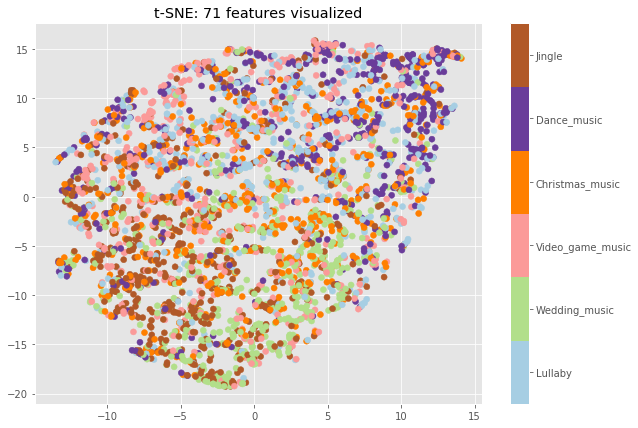

In [31]:
df_tsne = df.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

plt.figure(figsize=(10,7))
plt.title('t-SNE: 71 features visualized')  # using ' + str(n_comp) + ' PCA components'
plot = plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'], c=df_tsne['label'], cmap=plt.cm.get_cmap("Paired", 6))
cbar = plt.colorbar(ticks=range(6))
cbar.set_ticklabels(list(new_label_dict.keys()))

plt.clim(-0.5, 5.5)

plt.show()